# Calculate Nino 3.4 index to check if eruptions line up with El Nino events
This script opens up all the CMIP6 historical model run files with data on precipitation pr and surface temperature tas and loops over the files. It calculates the Nino3.4 index for the data to test which years have an El Nino event and if they occur after volcanic eruptions. 


In [1]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load

In [2]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [3]:
# use this to reload the function file if I make any edits to it
func = reload(func) 
func2 = reload(func2)

In [4]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/ts/gr1.5

v20200302


In [5]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon

huss  pr  psl  tas  ts	uas  vas  wap


In [6]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
ts_dir = '/historical/r1i1p1f1/Amon/ts/gr1.5/'
print(institution_dir, tas_dir, pr_dir, ts_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/ /historical/r1i1p1f1/Amon/ts/gr1.5/


## Read in model data

In [7]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [8]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [9]:
models_ts = func.read_models(institution_dir, ts_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model E3SM-1-0 has different time so is now removed
47 models have been successfully loaded into an xarray


In [10]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_ts.model), drop = True)
models_ts = models_ts.where(models_ts.model.isin(models_tas.model), drop = True)

#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_ts.model)

True

In [11]:
# get rid of models with issues
models = models_ts.drop_sel(model=['CIESM'])

In [12]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## Select out regions
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [13]:
# area weighting 
models_w = models*np.cos(models_ts.lat*(np.pi/180))

## Nino 3.4

In [14]:
# add the multi-model mean to the data-array
models_w_mmm = func.add_mmm(models_w)

In [17]:
# calculate the nino3.4 index for all models (and mmm) for every month
nino34_index = func.nino34(models_w_mmm, '1850-01', '1880-01')

# Figures

In [18]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [40]:
nino34_mmm = nino34_index.sel(model='ACCESS-CM2').ts.sel(time=slice('1873-08','1893-08'))

<AxesSubplot:ylabel='Sea surface temperature anomaly [$\\degree$C]'>

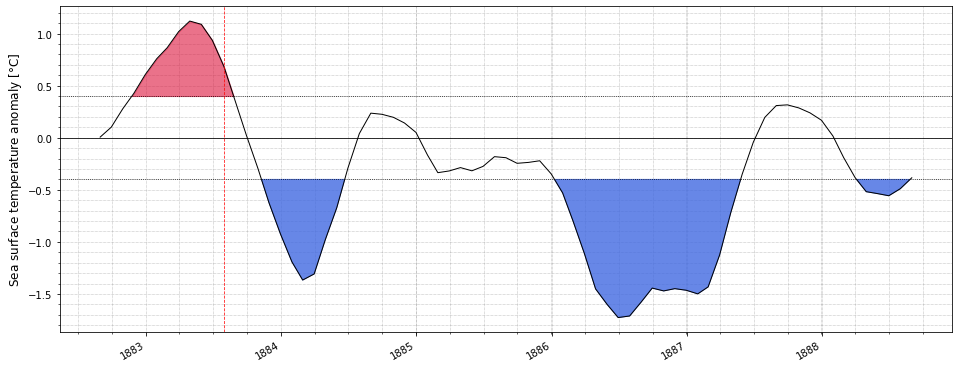

In [42]:
# plot time series of nino3.4 index for the multimodel mean dataset 
fig, axes = plt.subplots(figsize=(16,6))

func2.nino34_plot(nino34_mmm, e_date, ax = axes)

#plt.savefig('nino34_plot_mmm.png', dpi=300, bbox_inches='tight')

## next i want to classify each year as either el nino, la nino or neutral and then plot the results in a table 
to do this i need to count the number of el nino/la nina/ neutral events each year 
record count of dominant event for the year
then write the count and colour code (red el nino, blue la nina, white/grey neutral)  

# i want to do the below cell but have a count for each year 
# then i want to record the percentage of the highest event and colour code the cell that colour 

In [24]:
nino34_index

<xarray.Dataset>
Dimensions:  (model: 44, time: 1980)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2014-12-31
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'Multi-model mean'
    month    (time) int64 dask.array<chunksize=(5,), meta=np.ndarray>
Data variables:
    ts       (model, time) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>

In [21]:
# counts the number of el nino months in the time period and records it as a percentage 
nino_count = 100*(nino34_index.where(nino34_index>=0.4).count('time') / nino34_index.count('time'))
# counts the number of la nina months in the time period and records it as a percentage 
nina_count = 100*(nino34_index.where(nino34_index<=-0.4).count('time') / nino34_index.count('time'))
# counts the number of neutral months in the time period and records it as a percentage 
neutral_count = 100*(nino34_index.count('time')-nino_count-nina_count) / nino34_index.count('time')

In [29]:
import climtas

nino_events = climtas.event.find_events(nino34_index.sel(time=slice('1882-08','1888-08')).ts>=0.4, min_duration=5)
#nina_events = climtas.event.find_events(nino34_index.ts<=-0.4, min_duration=5)

In [32]:
nina_events = climtas.event.find_events(nino34_index.sel(time=slice('1882-08','1888-08')).ts<=-0.4, min_duration=5)

In [38]:
nino34_index = nino34_index.sel(time=slice('1882-08','1888-08'))

In [39]:
coords = climtas.event.event_coords(nino34_index, nino_events)
coords

,model,time,event_duration
0,CESM2-FV2,1882-08-31,212 days
1,BCC-CSM2-MR,1882-08-31,273 days
2,SAM0-UNICON,1882-08-31,303 days
3,E3SM-1-1,1882-08-31,334 days
4,KACE-1-0-G,1882-08-31,334 days
...,...,...,...
68,GISS-E2-1-G-CC,1887-03-31,NaT
69,MIROC6,1887-10-31,NaT
70,NorCPM1,1887-08-31,NaT
71,NorESM2-MM,1886-09-30,NaT


In [ ]:
# coords = climtas.event.event_coords(nino34_index, nino_events)

# def stat_func(event_data):
#     return {'min': event_data.min().values,
#             'min_date': event_data.time[event_data.argmin()].values}
    
# minimum = climtas.event.map_events(nino34_index, nino_events, nina_events)

# coords.join(minimum)

In [22]:
nino_count.to_dataframe()

,ts
model,
ACCESS-CM2,35.728745
ACCESS-ESM1-5,45.293522
AWI-CM-1-1-MR,46.356275
AWI-ESM-1-1-LR,41.548583
BCC-CSM2-MR,43.876518
BCC-ESM1,36.184211
CAMS-CSM1-0,36.690283
CAS-ESM2-0,34.969636
CESM2,34.817814


In [23]:
nina_count.to_dataframe()

,ts
model,
ACCESS-CM2,28.491903
ACCESS-ESM1-5,23.734818
AWI-CM-1-1-MR,22.368421
AWI-ESM-1-1-LR,22.368421
BCC-CSM2-MR,23.734818
BCC-ESM1,25.556680
CAMS-CSM1-0,29.453441
CAS-ESM2-0,32.135628
CESM2,29.149798


In [ ]:
for i, t in nino34_index.time:
    (nino34_index.where(nino34_index>=0.4).count('time') / nino34_index.count('time'))*100

In [ ]:
if nino_count > nina_count & nino_count > neutral_count:
    